In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from modules.householder import HH
from modules.couplings import NICE

In [3]:
train_dataset = datasets.MNIST("/storage/datasets", train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST("/storage/datasets", train=False, download=False, transform=transforms.ToTensor())

In [101]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 256
EPOCHS = 20

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, 
                                           shuffle=True, num_workers=7, pin_memory=use_cuda, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, 
                                          shuffle=False, num_workers=7, pin_memory=use_cuda, drop_last=True)

In [102]:
def net_slim(size):
    return nn.Sequential(
        nn.Conv2d(size, 64, kernel_size=1, padding=0, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, size, kernel_size=1, padding=0),
    )

In [103]:
class Downsample(nn.Module):
    


    def inverse(self, input):
        upscale_factor=2
        '''
        [:, C*r^2, H, W] -> [:, C, H*r, W*r]
        '''
        batch_size, in_channels, in_height, in_width = input.size()
        out_channels = in_channels // (upscale_factor**2)

        out_height = in_height * upscale_factor
        out_width = in_width * upscale_factor

        input_view = input.contiguous().view(batch_size, out_channels, upscale_factor,
                                             upscale_factor, in_height, in_width)

        output = input_view.permute(0, 1, 4, 2, 5, 3).contiguous()
        return output.view(batch_size, out_channels, out_height, out_width)


    def forward(self, input):
        downscale_factor=2
        '''
        [:, C, H*r, W*r] -> [:, C*r^2, H, W]
        '''
        batch_size, in_channels, in_height, in_width = input.size()
        out_channels = in_channels * (downscale_factor**2)

        out_height = in_height // downscale_factor
        out_width = in_width // downscale_factor

        input_view = input.contiguous().view(
            batch_size, in_channels, out_height, downscale_factor, out_width, downscale_factor
        )

        output = input_view.permute(0, 1, 3, 5, 2, 4).contiguous()
        return output.view(batch_size, out_channels, out_height, out_width)

In [104]:
def calculate_bits_per_pixel(ll, size=784):
    return 8 - ll / np.log(2) / size

In [109]:
class Sequential_VP_Flow(nn.Module):
    
    def __init__(self, distribution, flow_steps):
        super().__init__()
        self.flow_steps = nn.Sequential(*flow_steps)
        self.distribution = distribution
        
    def forward(self, x):
        return self.flow_steps(x)
    
    def inverse(self, z):
        for m in reversed(self.flow_steps):
            z = m.inverse(z)
        return z
    
    def log_prob(self, x):
        z = self.forward(x)
        z = z.view(z.size(0), -1)
        ll = self.distribution.log_prob(z).mean()
        return ll
    
    def sample(self):
        z = self.distribution.sample()[None]
        x = self.inverse(z)
        return x
    
class Housholder1x1Conv(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.v = nn.Parameter(torch.ones((channels,)))
        self.id = nn.Parameter(torch.eye(channels), requires_grad=False)
        self.channels = channels

    def forward(self, x):
        v = self.v
        w = self.id - 2 * v[:, None] @ v[None] / (v @ v)
        x = F.conv2d(x, w[..., None, None])
        # w is unitary so log_det = 0
        return x

    def inverse(self, x):
        v = self.v
        w = self.id - 2 * v[:, None] @ v[None] / (v @ v)
        x = F.conv2d(x, w[..., None, None])
        return x

In [110]:
dist = torch.distributions.MultivariateNormal(torch.zeros(IM_SIZE).to(device), torch.eye(IM_SIZE).to(device))
flow = Sequential_VP_Flow(dist, 
                          flow_steps=[ # 1
                              Downsample(), # 4
                              Housholder1x1Conv(4),
                              NICE(net_slim(2)),
                              Housholder1x1Conv(4),
                              NICE(net_slim(2)),
                              Downsample(),
                              Housholder1x1Conv(16),
                              NICE(net_slim(8)),
                              Housholder1x1Conv(16),
                              NICE(net_slim(8)),
                          ])
flow.to(device)

Sequential_VP_Flow(
  (flow_steps): Sequential(
    (0): Downsample()
    (1): Housholder1x1Conv()
    (2): NICE(
      (net): Sequential(
        (0): Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (3): Housholder1x1Conv()
    (4): NICE(
      (net): Sequential(
        (0): Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4)

In [112]:
optimizer = optim.Adam(flow.parameters(), 5e-3)

In [116]:
for i in range(EPOCHS):
    bits_total = []
    for x, _ in train_loader:
        x = x.to(device)
        with torch.no_grad():
            x = (x * (256 - 1) + torch.rand_like(x).to(device)) / 256
        optimizer.zero_grad()
        z = flow(x)
        loss = z.pow(2).mean()
        loss.backward()
        print(loss)
        optimizer.step()

tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0072, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0073, device='cuda:0',

tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0',

tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0',

tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0',

tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0',

tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0',

tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0',

tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0',

tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0052, device='cuda:0',

KeyboardInterrupt: 

In [115]:
x.max()

tensor(1.0000, device='cuda:0')

In [98]:
z = flow.distribution.sample()

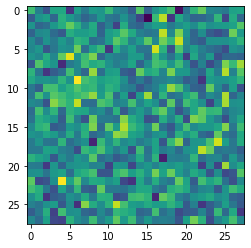

In [100]:
plt.imshow(flow.inverse(z.view(1, 16, 7, 7).cuda()).cpu().detach()[0, 0])